In [22]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import wordnet 
from nltk.corpus import stopwords
# nltk.download('wordnet')
# nltk.download('stopwords')
import string
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm_notebook
import random

In [31]:
# utility functions

# display image and caption from thumbnails folder given list of ids
def show_images(imgids, image_to_caption):
    for img in imgids:
        try:
            plt.figure();
            print('Caption:', image_to_caption[img])
            img=mpimg.imread('../data/thumbnail/'+img+'.jpg')
            imgplot = plt.imshow(img);
        except:
            plt.close()
            print(img)
        print()
    plt.show()
    
# draw random test id and exclude from train data
def train_test(train):
    test_id = random.choice(train.index)
    test_tags = train.pop(item = test_id)
    return test_id, test_tags, train

In [8]:
# KNN model
class KNN():
    # @param k: number of neighbors to return
    def __init__(self, k, article_to_image):
        self.k = k
        self.article_to_image = article_to_image

    # @param train: training set of articles
    # @article_to_image: map of images associated with each article
    def fit(self, train):
        self.train = train

    # returns number of normalized exact tag overlap
    def baseline_score(self,t0,t1):
        return len(set(t0) & set(t1))/len(t0)

    # @param sim: function to return similarity score
    # @param test: article to predict in form (id, tags)
    # TODO: implement sep functions for text train and image train
    def predict(self, test_tags):
        ranks = {}
        train = self.train.copy()
        train_ids, train_tags_all = train.index, train.values

        # go through ids
        for ind in range(len(train_ids)):
            train_id, train_tags = train_ids[ind], train_tags_all[ind]
            s = self.baseline_score(train_tags, test_tags)
            if len(ranks) < self.k:
                ranks[len(ranks)] = (train_id, s)
            elif s > min(ranks.values(), key=lambda x:x[1])[1]:
                key = min(ranks.keys(), key=lambda x:ranks[x][1])
                ranks[key] = (train_id, s)
        ranks = sorted(ranks.values(), key = lambda x:x[1], reverse=True)

        # map to predicted images
        train_ids = []
        pred = {}
        for train_id, s in ranks:
            img_ids = self.article_to_image[str(train_id)]
            for img_id in img_ids:
                pred[img_id] = s
            train_ids.append(train_id)
        return train_ids, pred

    def score(self):
        pass

In [9]:
# clean training data 
datadir = '../data/clean_data/'

tag_ref = {'ap_category':'category_code',
           'event':'event_tag',
           'org':'org_tag',
           'org_industry':'org_industry_tag',
           'person':'person_tag',
           'person_team':'person_team_tag',
           'person_type':'person_type',
           'place':'place_tag',
           'subject':'subject_tag',
           'summary':'headline_extended'
          }

article_feat_csvs = ['article_person.csv','article_org.csv','article_place.csv','article_subject.csv']
train = pd.Series([])
for csv_file in tqdm_notebook(os.listdir(datadir)):
    if csv_file in article_feat_csvs: 
        df = pd.read_csv(datadir+csv_file)
        feat = csv_file[8:-4]
        g = df.groupby("id")[tag_ref[feat]]
        if train.empty:
            train = g.apply(lambda x: list(x.astype(str).str.lower()))
        else:
            g = g.apply(lambda x: list(x.astype(str).str.lower()))
            train = train.combine(g, lambda x1, x2: list(set(x1+x2)), fill_value=[])

In [28]:
# map article-image associations
df = pd.read_csv(datadir + 'image_summary.csv')
g = df.groupby("article_idx")['id']
article_images = g.apply(list).to_dict()
image_to_caption = df.set_index('id')['summary']

In [39]:
# knn example use case

# test article
test_id, test_tags, train_data = train_test(train)
print('Test Article Tags:', test_tags)
print()
show_images(article_images[test_id], image_to_caption)

Test Article Tags: ['bernie sanders', 'hillary clinton', 'jackie cilley', 'presidential elections', 'campaigns', 'elizabeth warren', 'government and politics', 'sherrod brown', 'political endorsements', 'elections', 'state elections', 'united states presidential election', 'u.s. democratic party', 'nan', 'national elections', 'kamala harris', 'kirsten gillibrand']

Caption: In this March 3, 2019, photo, Sen. Bernie Sanders, I-Vt., smiles as he kicks off his 2020 presidential campaign at Navy Pier in Chicago. (AP Photo/Nam Y. Huh)
616ed3077371436086cd27ac09b2da99



Caption: IN this March 24, 2019, photo, President Donald Trump gives two thumbs up after stepping off Marine One on the South Lawn of the White House in Washington. Trump once compared Hillary Clinton’s campaign to the lumbering federal bureaucracy, but now he’s building one of his own. Trump may still consider himself his own best strategist and communicator, but this time he’s leaving nothing to chance. Says Trump campaign manager Brad Parscale: “We are creating the largest and most efficient campaign operation in American history with the ability to reach more voters than ever before.” (AP Photo/Alex Brandon)
3e043b149f7f47c39dcefff6b3f348b9

Caption: FILE - In this June 7, 2016 file photo, Democratic presidential candidate Sen. Bernie Sanders, I-Vt., speaks at a rally in Santa Monica, Calif. By the time California's presidential primary finally arrived in 2016,  Sanders was a beaten man. This time around, everything has changed. Sanders arrives in California this week for rallies i

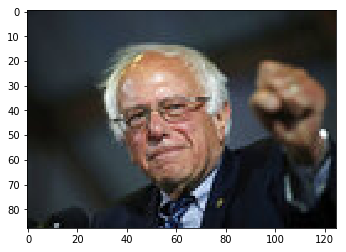

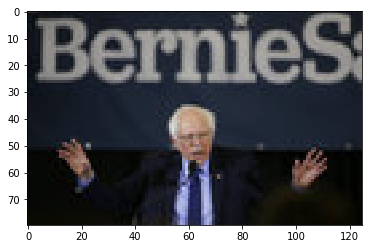

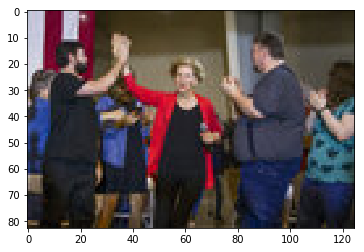

In [40]:
# model output

model = KNN(3, article_images)
model.fit(train_data)
train_ids, preds = model.predict(test_tags)
show_images(preds.keys(), image_to_caption)